In [ ]:
import pandas as pd
from difflib import get_close_matches

# Read the data
ig = pd.read_csv("/content/drive/MyDrive/Database Systems & Python/social media influencers - instagram.csv")
yt = pd.read_csv("/content/drive/MyDrive/Database Systems & Python/social media influencers - youtube.csv")
tt = pd.read_csv("/content/drive/MyDrive/Database Systems & Python/social media influencers - tiktok.csv")

In [ ]:
tt.head()

,Tiktoker name,Tiktok name,Subscribers count,Views avg.,Likes avg,Comments avg.,Shares avg
0,ekin.721,MOMO’s,221.7K,26M,2.8M,29.4K,116.4K
1,dojacat,Doja Cat,22.2M,25.4M,5M,36.7K,46.8K
2,kiet.ac.quy,Kiệt Ắk Wỷ,2.1M,20.7M,3.5M,38.8K,33.9K
3,charlidamelio,charli d’amelio,135.4M,18.7M,2.6M,54.7K,35.2K
4,luvadepedreiro,Iran Ferreira (Lai),11.4M,24.8M,2.6M,32.7K,26.8K


In [ ]:
# Switch the M, K to the number
def clean_number(value):
    if isinstance(value, str):
        value = value.replace(",", "").strip()
        if "M" in value:
            return float(value.replace("M", "")) * 1_000_000
        elif "K" in value:
            return float(value.replace("K", "")) * 1_000
        else:
            try:
                return float(value)
            except:
                return None
    return value

ig["Followers"] = ig["Followers"].apply(clean_number)
ig["Engagement avg\r\n"] = ig["Engagement avg\r\n"].apply(clean_number)

yt["avg views"] = yt["avg views"].apply(clean_number)
yt["avg likes"] = yt["avg likes"].apply(clean_number)
yt["avg comments"] = yt["avg comments"].apply(clean_number)

tt["Shares avg"] = tt["Shares avg"].apply(clean_number)

In [ ]:
yt.head()

,youtuber name,channel name,Category,Subscribers,Audience Country,avg views,avg likes,avg comments
0,tseries,T-Series,Music & Dance,212.1M,India,323700.0,9800.0,290.0
1,checkgate,Cocomelon - Nursery Rhymes,Education,132.1M,NaN,13800000.0,80900.0,NaN
2,setindia,SET India,NaN,130.4M,India,23600.0,314.0,21.0
3,PewDiePie,PewDiePie,Animation,111.4M,United States,1400000.0,80800.0,4600.0
4,MrBeast6000,MrBeast,Video games,92.5M,United States,30600000.0,1700000.0,67700.0


In [ ]:
# Build the influencer table
influencer_df = yt[["youtuber name", "Category", "Audience Country"]].copy()
influencer_df.columns = ["name", "category", "audience_country"]
influencer_df = influencer_df.drop_duplicates().reset_index(drop=True)
influencer_df["influencer_id"] = influencer_df.index + 1

In [ ]:
# Build the platform table
platform_df = pd.DataFrame({
    "platform_id": [1, 2, 3],
    "name": ["Instagram", "TikTok", "YouTube"]
})

In [ ]:
# Compare the name of IG and Tiltok to match the Youtube table
ig_names = ig["Influencer insta name"].dropna().unique()
tt_names = tt["Tiktoker name"].dropna().unique()
yt_names = yt["youtuber name"].dropna().unique()

ig_name_map = {}
for ig_name in ig_names:
    match = get_close_matches(ig_name, yt_names, n=1, cutoff=0.6)
    if match:
        ig_name_map[ig_name] = match[0]

tt_name_map = {}
for tt_name in tt_names:
    match = get_close_matches(tt_name, yt_names, n=1, cutoff=0.6)
    if match:
        tt_name_map[tt_name] = match[0]

ig["Influencer insta name"] = ig["Influencer insta name"].replace(ig_name_map)
tt["Tiktoker name"] = tt["Tiktoker name"].replace(tt_name_map)

In [ ]:
# Build the metrics table
# IG（platform_id = 1）
ig_metrics = ig[["Influencer insta name", "Followers", "Engagement avg\r\n"]].copy()
ig_metrics.columns = ["name", "followers_count", "engagement_avg"]
ig_metrics = pd.merge(influencer_df[["influencer_id", "name"]], ig_metrics, on="name", how="inner")
ig_metrics["m_platform_id"] = 1
ig_metrics["average_views"] = None
ig_metrics["average_likes"] = None
ig_metrics["average_comments"] = None
ig_metrics["shares_avg"] = None

# TikTok（platform_id = 2）
tt_metrics = tt[["Tiktoker name", "Shares avg"]].copy()
tt_metrics.columns = ["name", "shares_avg"]
tt_metrics = pd.merge(influencer_df[["influencer_id", "name"]], tt_metrics, on="name", how="inner")
tt_metrics["m_platform_id"] = 2
tt_metrics["followers_count"] = None
tt_metrics["average_views"] = None
tt_metrics["average_likes"] = None
tt_metrics["average_comments"] = None
tt_metrics["engagement_avg"] = None

# YouTube（platform_id = 3）
yt_metrics = yt[["youtuber name", "avg views", "avg likes", "avg comments"]].copy()
yt_metrics.columns = ["name", "average_views", "average_likes", "average_comments"]
yt_metrics = pd.merge(influencer_df[["influencer_id", "name"]], yt_metrics, on="name", how="inner")
yt_metrics["m_platform_id"] = 3
yt_metrics["followers_count"] = None
yt_metrics["engagement_avg"] = None
yt_metrics["shares_avg"] = None

In [ ]:
# Combibe metrics table
metrics_df = pd.concat([ig_metrics, tt_metrics, yt_metrics], ignore_index=True)
metrics_df["metric_id"] = metrics_df.index + 1
metrics_df = metrics_df[[
    "metric_id", "influencer_id", "m_platform_id", "followers_count",
    "average_views", "average_likes", "average_comments",
    "engagement_avg", "shares_avg"
]]

<ipython-input-7-2a162d86aaaf>:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([ig_metrics, tt_metrics, yt_metrics], ignore_index=True)


In [ ]:
# Export the result
influencer_df.to_csv("influencer.csv", index=False)
platform_df.to_csv("platform.csv", index=False)
metrics_df.to_csv("metrics.csv", index=False)

print("Done")

Done


Project Phase 3

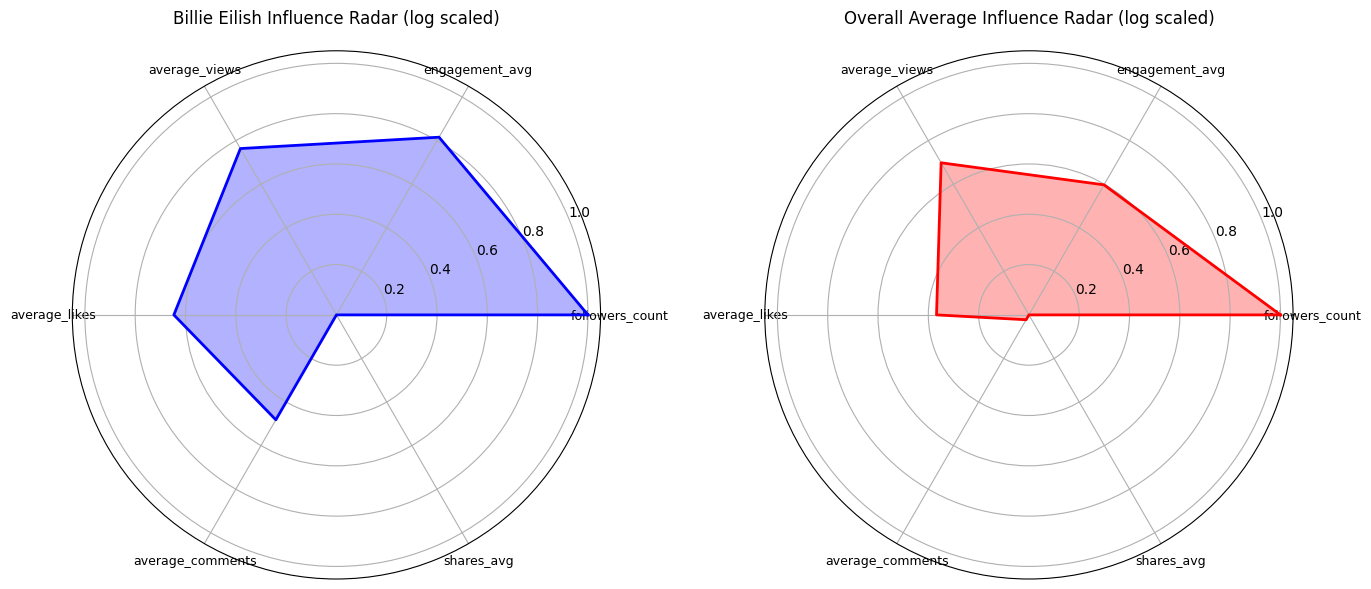

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Read the CSV
df = pd.read_csv("/content/drive/MyDrive/Database Systems & Python/i2.csv")

# Set the indicators
metrics = ["followers_count", "engagement_avg", "average_views", "average_likes", "average_comments", "shares_avg"]

# Calculate the mean
billie_mean = df[df["influencer_name"] == "Billie Eilish"][metrics].mean(skipna=True)
overall_mean = df[metrics].mean(skipna=True)

# Transform with log10
billie_log = np.log10(billie_mean.fillna(0) + 1)
overall_log = np.log10(overall_mean.fillna(0) + 1)

# Normalization (MinMax)
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
billie_scaled = scaler1.fit_transform(billie_log.values.reshape(-1, 1)).flatten()
overall_scaled = scaler2.fit_transform(overall_log.values.reshape(-1, 1)).flatten()

# Build the Radar Chart
labels = metrics
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]
billie_values = billie_scaled.tolist() + [billie_scaled[0]]
overall_values = overall_scaled.tolist() + [overall_scaled[0]]

fig, axs = plt.subplots(1, 2, subplot_kw=dict(polar=True), figsize=(14, 6))

# Take Billie Eilish as an example
axs[0].plot(angles, billie_values, color='blue', linewidth=2)
axs[0].fill(angles, billie_values, color='blue', alpha=0.3)
axs[0].set_title("Billie Eilish Influence Radar (log scaled)", pad=20)
axs[0].set_xticks(angles[:-1])
axs[0].set_xticklabels(labels, fontsize=9)
axs[0].grid(True)

# Overall
axs[1].plot(angles, overall_values, color='red', linewidth=2)
axs[1].fill(angles, overall_values, color='red', alpha=0.3)
axs[1].set_title("Overall Average Influence Radar (log scaled)", pad=20)
axs[1].set_xticks(angles[:-1])
axs[1].set_xticklabels(labels, fontsize=9)
axs[1].grid(True)

plt.tight_layout()
plt.show()

<ipython-input-6-b403eac59dbc>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=platform_avg_score.index, y=platform_avg_score.values, palette='Set2')


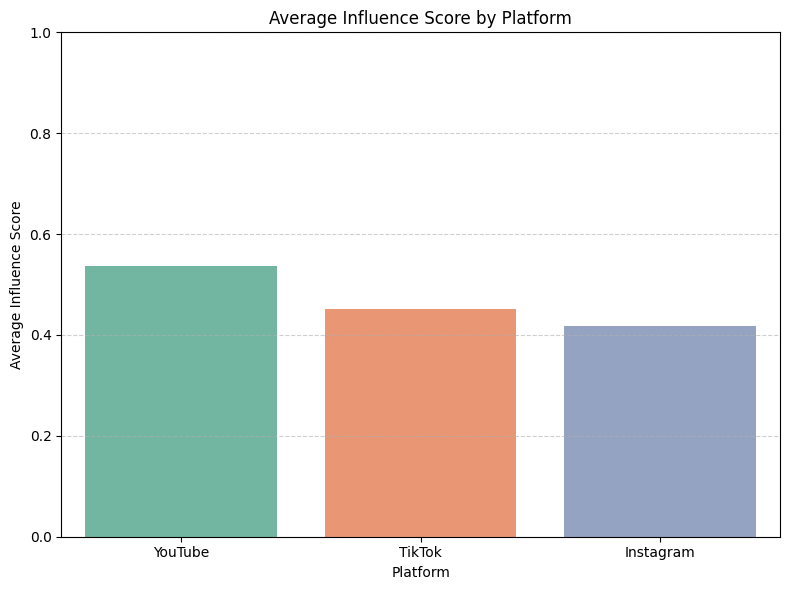

<ipython-input-6-b403eac59dbc>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="platform", y="influence_score", data=df_cleaned, palette='Set2')


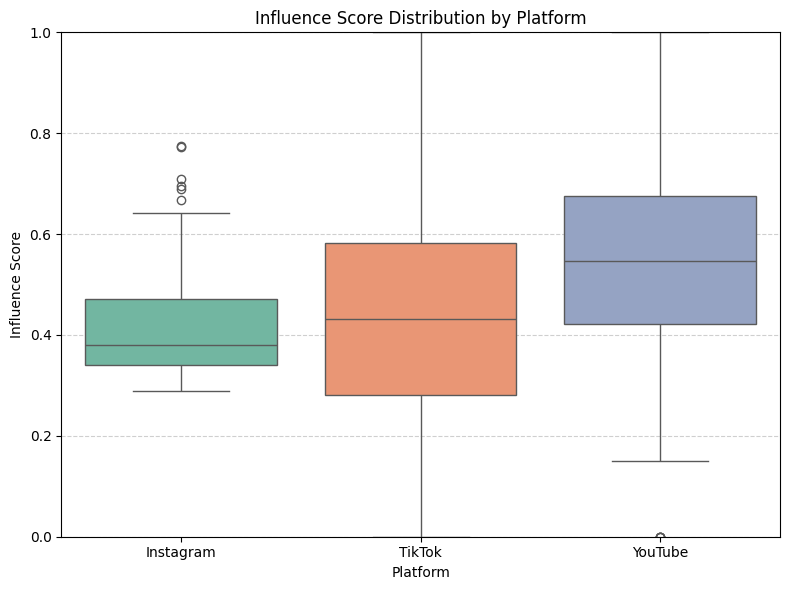

In [ ]:
# Read the CSV & Set the indicator
df = pd.read_csv("/content/drive/MyDrive/Database Systems & Python/i2.csv")
metrics = ["followers_count", "engagement_avg", "average_views", "average_likes", "average_comments", "shares_avg"]

# Clean the data
df_cleaned = df.dropna(subset=["platform", *metrics], how='all')

# Transform with log10
for col in metrics:
    df_cleaned[f"log_{col}"] = np.log10(df_cleaned[col] + 1)

# MinMax normalize
scaler = MinMaxScaler()
log_metrics = [f"log_{m}" for m in metrics]
df_cleaned[log_metrics] = scaler.fit_transform(df_cleaned[log_metrics])

# Set the Score
df_cleaned["influence_score"] = df_cleaned[log_metrics].mean(axis=1)

# Calculate the average score by platform
platform_avg_score = df_cleaned.groupby("platform")["influence_score"].mean().sort_values(ascending=False)

# Plot the Bar Chart
plt.figure(figsize=(8, 6))
sns.barplot(x=platform_avg_score.index, y=platform_avg_score.values, palette='Set2')
plt.title("Average Influence Score by Platform")
plt.ylabel("Average Influence Score")
plt.xlabel("Platform")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot the Box Plot
plt.figure(figsize=(8, 6))
sns.boxplot(x="platform", y="influence_score", data=df_cleaned, palette='Set2')
plt.title("Influence Score Distribution by Platform")
plt.ylabel("Influence Score")
plt.xlabel("Platform")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

<ipython-input-2-aa13e3390c6f>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=platform_avg_score.index, y=platform_avg_score.values, palette='Set2')


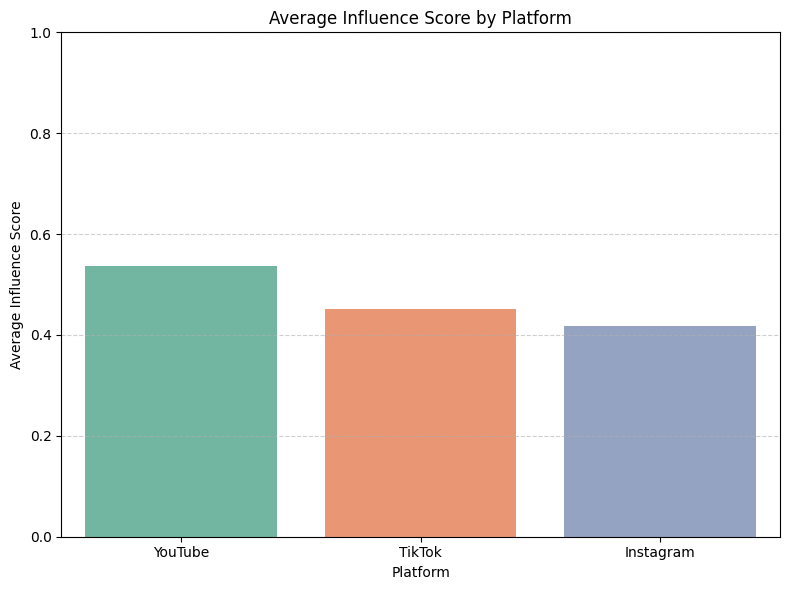

<ipython-input-2-aa13e3390c6f>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


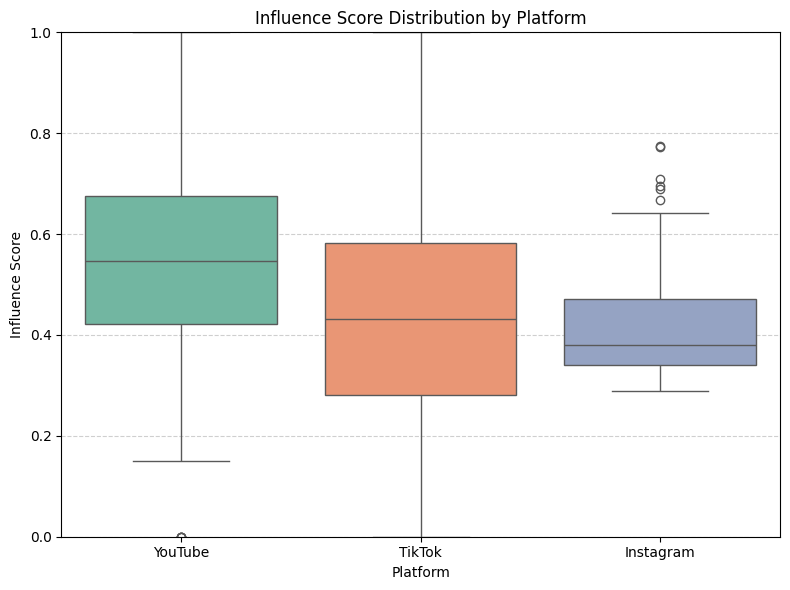

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 讀資料
df = pd.read_csv("/content/drive/MyDrive/Database Systems & Python/i2.csv")
metrics = ["followers_count", "engagement_avg", "average_views", "average_likes", "average_comments", "shares_avg"]

# 清理資料（移除六項全為 NaN 的）
df_cleaned = df.dropna(subset=["platform", *metrics], how='all')

# Step 1: log10(x + 1) 轉換
for col in metrics:
    df_cleaned[f"log_{col}"] = np.log10(df_cleaned[col] + 1)

# Step 2: MinMax normalize
scaler = MinMaxScaler()
log_metrics = [f"log_{m}" for m in metrics]
df_cleaned[log_metrics] = scaler.fit_transform(df_cleaned[log_metrics])

# Step 3: 綜合分數
df_cleaned["influence_score"] = df_cleaned[log_metrics].mean(axis=1)

# Step 4: 平台平均分數
platform_avg_score = df_cleaned.groupby("platform")["influence_score"].mean().sort_values(ascending=False)
platform_order = platform_avg_score.index.tolist()

# 繪圖 1️⃣：Bar Chart (平均值)
plt.figure(figsize=(8, 6))
sns.barplot(x=platform_avg_score.index, y=platform_avg_score.values, palette='Set2')
plt.title("Average Influence Score by Platform")
plt.ylabel("Average Influence Score")
plt.xlabel("Platform")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 繪圖 2️⃣：Boxplot (分佈) — 強制平台順序
plt.figure(figsize=(8, 6))
sns.boxplot(
    x="platform",
    y="influence_score",
    data=df_cleaned,
    order=platform_order,   # 💡 指定順序
    palette='Set2'
)
plt.title("Influence Score Distribution by Platform")
plt.ylabel("Influence Score")
plt.xlabel("Platform")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
